In [1]:
import os
import torch
import pandas as pd
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# import torchvision.transforms.functional
# import torchvision.transforms.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from torchinfo import summary
from tqdm import tqdm

# Planet : Amazon space -- Full model running for multilabel classification

!! This is supposed to become the main jupyternotebook to run the multilabel classification and testing !!

Usefull links:
<https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/>

## 0) Initialization
### 0.1) Getting Module and Functions

In [2]:
from Multi_Model_Amazon_Engine import train_dual, batch_prediction_dual
from Multi_Model_Amazon_Module import AmazonSpaceDual, GroundCNN, CloudCNN, AdjustSaturation

In [3]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

## 1) Putting the model on the gpu

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [5]:
ground_model = GroundCNN().to(device)
cloud_model = CloudCNN().to(device)

### + Load previously trained model

In [6]:
if not os.path.exists('ground_model_multilabel_classification.pth'):
    print('Did not find ground pretrained model file')
if not os.path.exists('cloud_model_classification.pth'):
    print('Did not find cloud pretrained model file')
else:
    if device=="cpu":
        ground_model.load_state_dict(torch.load('ground_model_multilabel_classification.pth', map_location=torch.device('cpu')))
        cloud_model.load_state_dict(torch.load('cloud_model_classification.pth', map_location=torch.device('cpu')))
    else:
        ground_model.load_state_dict(torch.load('ground_model_multilabel_classification.pth'))
        cloud_model.load_state_dict(torch.load('cloud_model_classification.pth'))

Did not find ground pretrained model file
Did not find cloud pretrained model file


In [7]:
summary(ground_model, input_size=(128,3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
GroundCNN                                [128, 14]                 --
├─BatchNorm2d: 1-1                       [128, 3, 256, 256]        6
├─Conv2d: 1-2                            [128, 10, 252, 252]       760
├─MaxPool2d: 1-3                         [128, 10, 84, 84]         --
├─Dropout: 1-4                           [128, 10, 84, 84]         --
├─Conv2d: 1-5                            [128, 20, 80, 80]         5,020
├─AvgPool2d: 1-6                         [128, 20, 26, 26]         --
├─Dropout: 1-7                           [128, 20, 26, 26]         --
├─Conv2d: 1-8                            [128, 60, 22, 22]         30,060
├─MaxPool2d: 1-9                         [128, 60, 7, 7]           --
├─Dropout: 1-10                          [128, 60, 7, 7]           --
├─Linear: 1-11                           [128, 1000]               2,941,000
├─Dropout: 1-12                          [128, 1000]               --
├

In [8]:
summary(cloud_model, input_size=(128,3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CloudCNN                                 [128, 3]                  --
├─BatchNorm2d: 1-1                       [128, 3, 256, 256]        6
├─Conv2d: 1-2                            [128, 10, 247, 247]       3,010
├─MaxPool2d: 1-3                         [128, 10, 61, 61]         --
├─Dropout: 1-4                           [128, 10, 61, 61]         --
├─Conv2d: 1-5                            [128, 30, 57, 57]         7,530
├─AvgPool2d: 1-6                         [128, 30, 14, 14]         --
├─Dropout: 1-7                           [128, 30, 14, 14]         --
├─Linear: 1-8                            [128, 100]                588,100
├─Linear: 1-9                            [128, 3]                  303
├─Softmax: 1-10                          [128, 3]                  --
Total params: 598,949
Trainable params: 598,949
Non-trainable params: 0
Total mult-adds (G): 26.71
Input size (MB): 100.66
Forward/backward pass

## 2) Getting the different datasets

In [14]:
train_csv = 'training.csv'
validation_csv = 'validation.csv'
test_csv = 'test.csv'

In [15]:
# Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),transforms.RandomAutocontrast(p=1), AdjustSaturation(1.2)])
Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256)])

In [16]:
train_dataset = AmazonSpaceDual(csv_file=train_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
validation_dataset = AmazonSpaceDual(csv_file=validation_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
test_dataset = AmazonSpaceDual(csv_file=test_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

## 3) Wrapping into the different dataloaders

In [17]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size,shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True, drop_last=True)

## 4) Choice of Criterion and Opitimizer

In [18]:
learning_rate = 0.01

ground_crit = nn.BCEWithLogitsLoss()
cloud_crit = nn.BCELoss()

ground_optim = torch.optim.Adam(ground_model.parameters(), lr=learning_rate)
cloud_optim = torch.optim.Adam(cloud_model.parameters(), lr=learning_rate)

## 5) TRAINING

Training


1it [00:02,  2.15s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.243macro f1: 0.153 samples f1: 0.239loss 1.298
Ground metrics: micro f1: 0.125macro f1: 0.084 samples f1: 0.117 loss 0.695
Cloud metrics : 0.78125 and loss:0.6029409766197205


31it [00:50,  1.59s/it]

iter: 30 training:micro f1: 0.638macro f1: 0.106 samples f1: 0.660loss 17.475
Ground metrics:micro f1: 0.580macro f1: 0.069 samples f1: 0.654loss 0.287
Cloud metrics : 0.7109375 and loss:17.1875


61it [01:39,  1.66s/it]

iter: 60 training:micro f1: 0.650macro f1: 0.102 samples f1: 0.659loss 20.786
Ground metrics:micro f1: 0.630macro f1: 0.068 samples f1: 0.681loss 0.213
Cloud metrics : 0.65625 and loss:20.572917938232422


90it [02:25,  1.61s/it]

iter: 90 training:micro f1: 0.700macro f1: 0.109 samples f1: 0.727loss 14.533
Ground metrics:micro f1: 0.647macro f1: 0.070 samples f1: 0.720loss 0.210
Cloud metrics : 0.765625 and loss:14.322916984558105


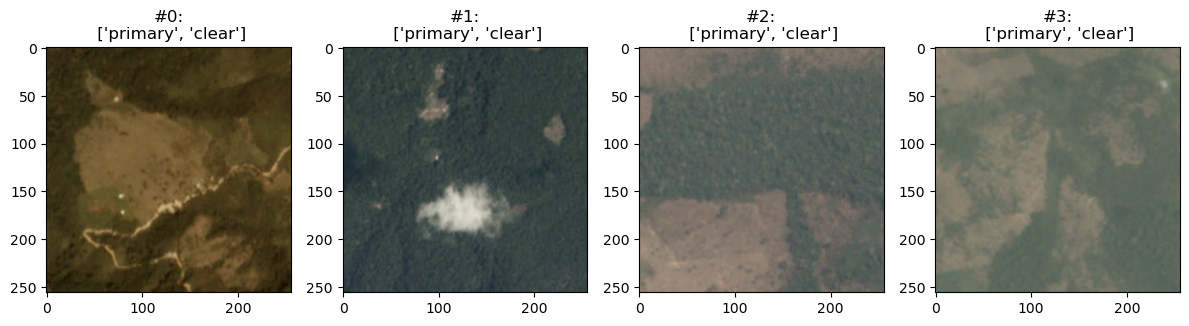

121it [03:18,  1.69s/it]

iter:120 training:micro f1: 0.688macro f1: 0.107 samples f1: 0.718loss 14.807
Ground metrics:micro f1: 0.635macro f1: 0.069 samples f1: 0.719loss 0.223
Cloud metrics : 0.734375 and loss:14.583333969116211


151it [04:06,  1.59s/it]

iter:150 training:micro f1: 0.662macro f1: 0.105 samples f1: 0.672loss 18.702
Ground metrics:micro f1: 0.628macro f1: 0.069 samples f1: 0.687loss 0.212
Cloud metrics : 0.6953125 and loss:18.48958396911621


180it [04:52,  1.66s/it]

iter:180 training:micro f1: 0.626macro f1: 0.104 samples f1: 0.639loss 19.256
Ground metrics:micro f1: 0.577macro f1: 0.068 samples f1: 0.631loss 0.246
Cloud metrics : 0.6796875 and loss:19.010417938232422


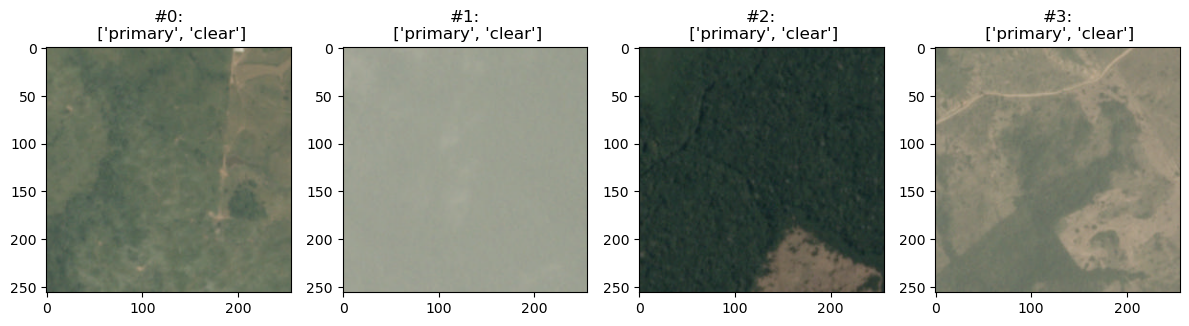

187it [05:04,  1.63s/it]


Validating


62it [01:13,  1.19s/it]


Training


1it [00:01,  1.35s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.682macro f1: 0.107 samples f1: 0.706loss 15.575
Ground metrics: micro f1: 0.630macro f1: 0.069 samples f1: 0.701 loss 0.210
Cloud metrics : 0.7421875 and loss:15.364583969116211


31it [00:47,  1.59s/it]

iter: 30 training:micro f1: 0.662macro f1: 0.105 samples f1: 0.674loss 17.671
Ground metrics:micro f1: 0.621macro f1: 0.069 samples f1: 0.683loss 0.224
Cloud metrics : 0.6953125 and loss:17.447917938232422


61it [01:33,  1.53s/it]

iter: 60 training:micro f1: 0.633macro f1: 0.103 samples f1: 0.648loss 21.064
Ground metrics:micro f1: 0.609macro f1: 0.069 samples f1: 0.674loss 0.230
Cloud metrics : 0.640625 and loss:20.83333396911621


90it [02:18,  1.52s/it]

iter: 90 training:micro f1: 0.663macro f1: 0.105 samples f1: 0.677loss 18.710
Ground metrics:micro f1: 0.630macro f1: 0.069 samples f1: 0.696loss 0.221
Cloud metrics : 0.6953125 and loss:18.48958396911621


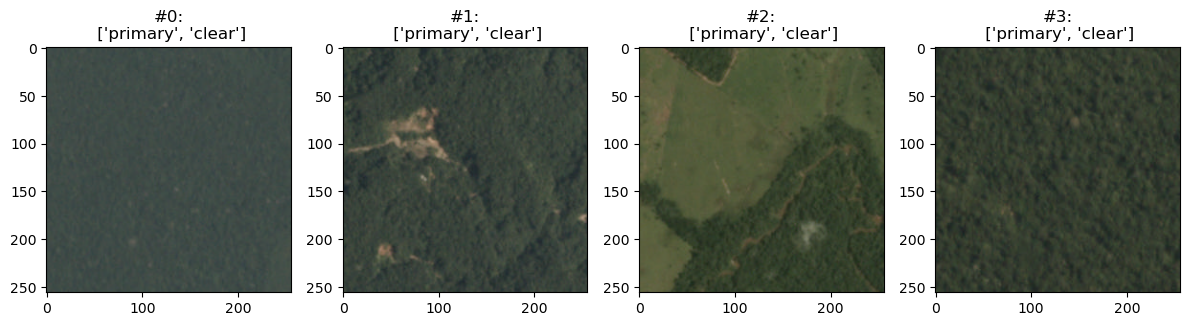

121it [03:08,  1.56s/it]

iter:120 training:micro f1: 0.660macro f1: 0.106 samples f1: 0.669loss 17.153
Ground metrics:micro f1: 0.606macro f1: 0.068 samples f1: 0.655loss 0.226
Cloud metrics : 0.734375 and loss:16.92708396911621


151it [03:55,  1.58s/it]

iter:150 training:micro f1: 0.689macro f1: 0.107 samples f1: 0.703loss 15.056
Ground metrics:micro f1: 0.632macro f1: 0.068 samples f1: 0.683loss 0.212
Cloud metrics : 0.7578125 and loss:14.84375


180it [04:42,  1.59s/it]

iter:180 training:micro f1: 0.663macro f1: 0.103 samples f1: 0.680loss 22.332
Ground metrics:micro f1: 0.669macro f1: 0.069 samples f1: 0.726loss 0.196
Cloud metrics : 0.6328125 and loss:22.135417938232422


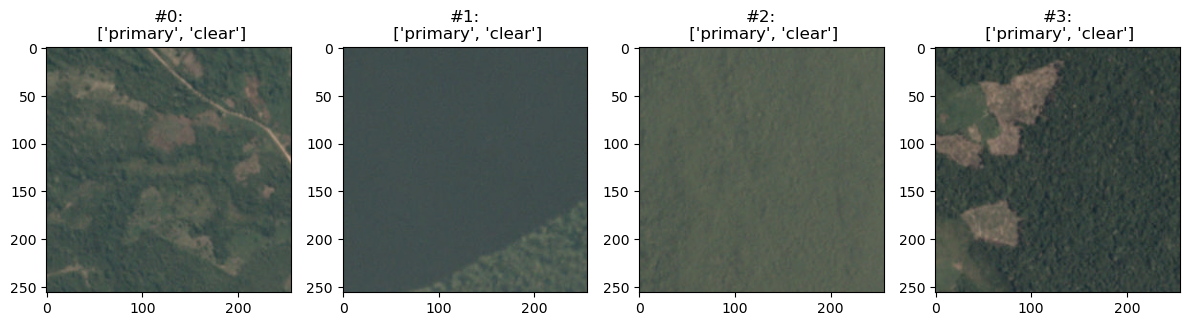

187it [04:55,  1.58s/it]


Validating


62it [01:04,  1.04s/it]


Training


1it [00:01,  1.38s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.663macro f1: 0.104 samples f1: 0.666loss 18.704
Ground metrics: micro f1: 0.628macro f1: 0.067 samples f1: 0.671 loss 0.215
Cloud metrics : 0.6953125 and loss:18.48958396911621


31it [00:51,  1.78s/it]

iter: 30 training:micro f1: 0.646macro f1: 0.105 samples f1: 0.655loss 18.722
Ground metrics:micro f1: 0.601macro f1: 0.069 samples f1: 0.653loss 0.233
Cloud metrics : 0.703125 and loss:18.48958396911621


61it [01:40,  1.61s/it]

iter: 60 training:micro f1: 0.693macro f1: 0.107 samples f1: 0.712loss 16.347
Ground metrics:micro f1: 0.652macro f1: 0.069 samples f1: 0.713loss 0.201
Cloud metrics : 0.734375 and loss:16.14583396911621


90it [02:28,  1.69s/it]

iter: 90 training:micro f1: 0.643macro f1: 0.101 samples f1: 0.651loss 23.644
Ground metrics:micro f1: 0.646macro f1: 0.068 samples f1: 0.698loss 0.207
Cloud metrics : 0.6171875 and loss:23.4375


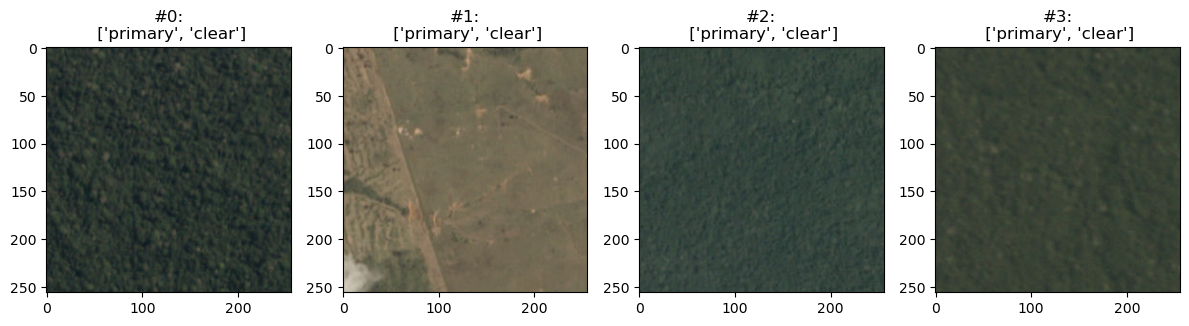

121it [03:20,  1.67s/it]

iter:120 training:micro f1: 0.700macro f1: 0.107 samples f1: 0.711loss 15.044
Ground metrics:micro f1: 0.652macro f1: 0.069 samples f1: 0.701loss 0.200
Cloud metrics : 0.75 and loss:14.84375


151it [04:09,  1.63s/it]

iter:150 training:micro f1: 0.697macro f1: 0.105 samples f1: 0.708loss 16.614
Ground metrics:micro f1: 0.663macro f1: 0.068 samples f1: 0.717loss 0.208
Cloud metrics : 0.71875 and loss:16.40625


180it [04:56,  1.58s/it]

iter:180 training:micro f1: 0.661macro f1: 0.106 samples f1: 0.681loss 16.893
Ground metrics:micro f1: 0.615macro f1: 0.070 samples f1: 0.682loss 0.226
Cloud metrics : 0.703125 and loss:16.666667938232422


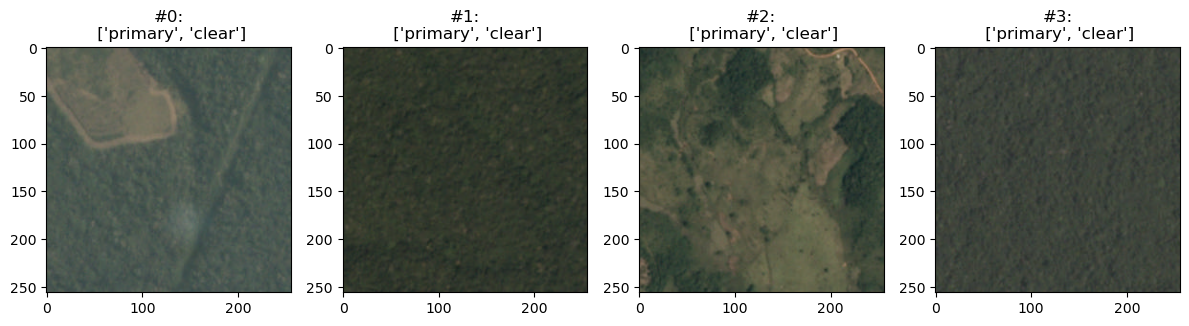

187it [05:08,  1.65s/it]


Validating


62it [01:06,  1.07s/it]


Training


1it [00:01,  1.48s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.672macro f1: 0.106 samples f1: 0.686loss 16.375
Ground metrics: micro f1: 0.622macro f1: 0.069 samples f1: 0.685 loss 0.229
Cloud metrics : 0.7265625 and loss:16.14583396911621


31it [00:49,  1.62s/it]

iter: 30 training:micro f1: 0.679macro f1: 0.105 samples f1: 0.698loss 17.135
Ground metrics:micro f1: 0.641macro f1: 0.069 samples f1: 0.712loss 0.208
Cloud metrics : 0.703125 and loss:16.92708396911621


61it [01:37,  1.62s/it]

iter: 60 training:micro f1: 0.680macro f1: 0.105 samples f1: 0.695loss 17.915
Ground metrics:micro f1: 0.650macro f1: 0.069 samples f1: 0.712loss 0.207
Cloud metrics : 0.6953125 and loss:17.70833396911621


90it [02:23,  1.54s/it]

iter: 90 training:micro f1: 0.657macro f1: 0.106 samples f1: 0.671loss 17.416
Ground metrics:micro f1: 0.607macro f1: 0.069 samples f1: 0.663loss 0.228
Cloud metrics : 0.71875 and loss:17.1875


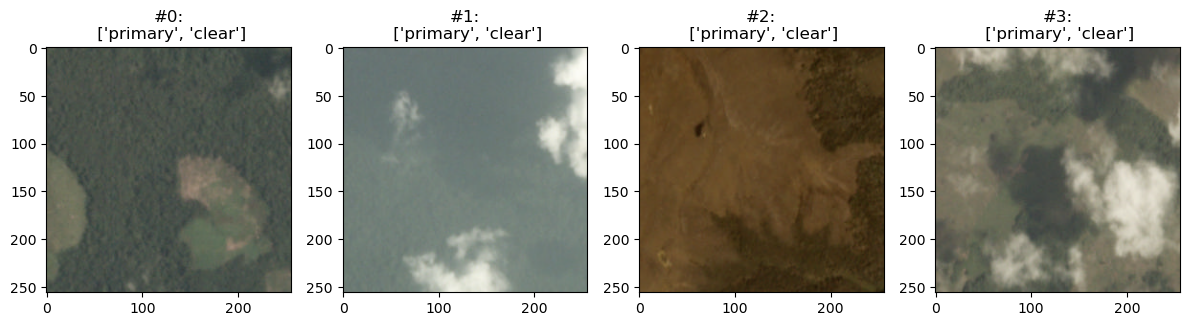

121it [03:13,  1.51s/it]

iter:120 training:micro f1: 0.681macro f1: 0.103 samples f1: 0.693loss 19.993
Ground metrics:micro f1: 0.678macro f1: 0.069 samples f1: 0.731loss 0.201
Cloud metrics : 0.6484375 and loss:19.791667938232422


151it [03:58,  1.60s/it]

iter:150 training:micro f1: 0.614macro f1: 0.102 samples f1: 0.629loss 22.128
Ground metrics:micro f1: 0.584macro f1: 0.068 samples f1: 0.638loss 0.253
Cloud metrics : 0.640625 and loss:21.875


180it [04:43,  1.57s/it]

iter:180 training:micro f1: 0.690macro f1: 0.105 samples f1: 0.702loss 17.906
Ground metrics:micro f1: 0.667macro f1: 0.069 samples f1: 0.730loss 0.197
Cloud metrics : 0.6953125 and loss:17.70833396911621


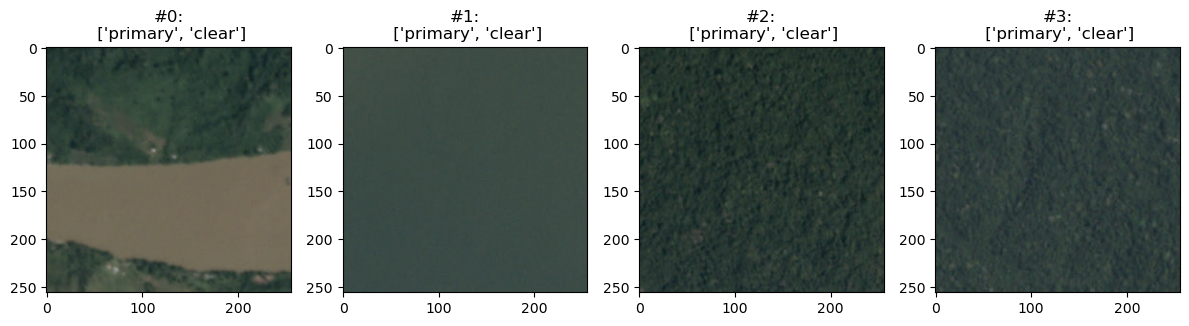

187it [04:54,  1.58s/it]


Validating


62it [01:04,  1.05s/it]


Training


1it [00:01,  1.60s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.674macro f1: 0.107 samples f1: 0.701loss 14.808
Ground metrics: micro f1: 0.616macro f1: 0.069 samples f1: 0.685 loss 0.224
Cloud metrics : 0.7265625 and loss:14.583333969116211


31it [00:52,  1.64s/it]

iter: 30 training:micro f1: 0.644macro f1: 0.105 samples f1: 0.667loss 19.509
Ground metrics:micro f1: 0.610macro f1: 0.070 samples f1: 0.684loss 0.238
Cloud metrics : 0.671875 and loss:19.27083396911621


61it [01:46,  1.87s/it]

iter: 60 training:micro f1: 0.644macro f1: 0.101 samples f1: 0.649loss 22.608
Ground metrics:micro f1: 0.641macro f1: 0.068 samples f1: 0.691loss 0.212
Cloud metrics : 0.6171875 and loss:22.39583396911621


90it [02:38,  1.84s/it]

iter: 90 training:micro f1: 0.660macro f1: 0.104 samples f1: 0.668loss 18.189
Ground metrics:micro f1: 0.621macro f1: 0.068 samples f1: 0.664loss 0.220
Cloud metrics : 0.6953125 and loss:17.96875


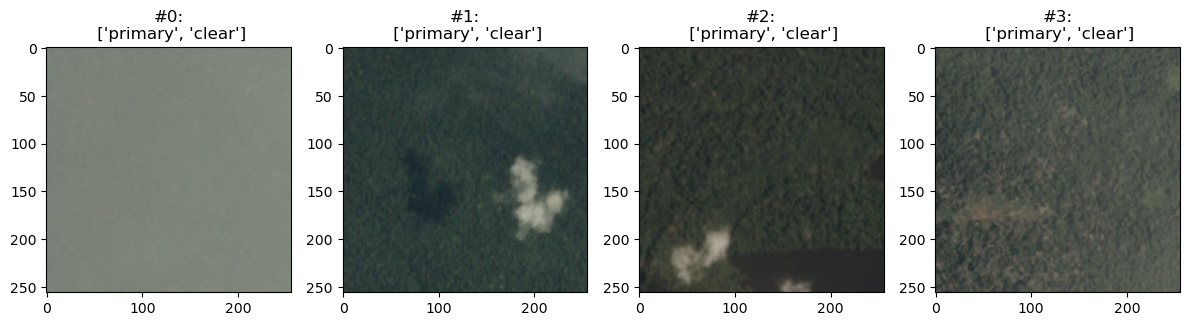

121it [03:31,  1.69s/it]

iter:120 training:micro f1: 0.689macro f1: 0.107 samples f1: 0.714loss 17.653
Ground metrics:micro f1: 0.661macro f1: 0.070 samples f1: 0.744loss 0.205
Cloud metrics : 0.7109375 and loss:17.447917938232422


151it [04:21,  1.58s/it]

iter:150 training:micro f1: 0.668macro f1: 0.105 samples f1: 0.677loss 18.192
Ground metrics:micro f1: 0.628macro f1: 0.068 samples f1: 0.685loss 0.223
Cloud metrics : 0.7109375 and loss:17.96875


180it [05:10,  1.71s/it]

iter:180 training:micro f1: 0.687macro f1: 0.107 samples f1: 0.711loss 15.066
Ground metrics:micro f1: 0.635macro f1: 0.069 samples f1: 0.711loss 0.222
Cloud metrics : 0.734375 and loss:14.84375


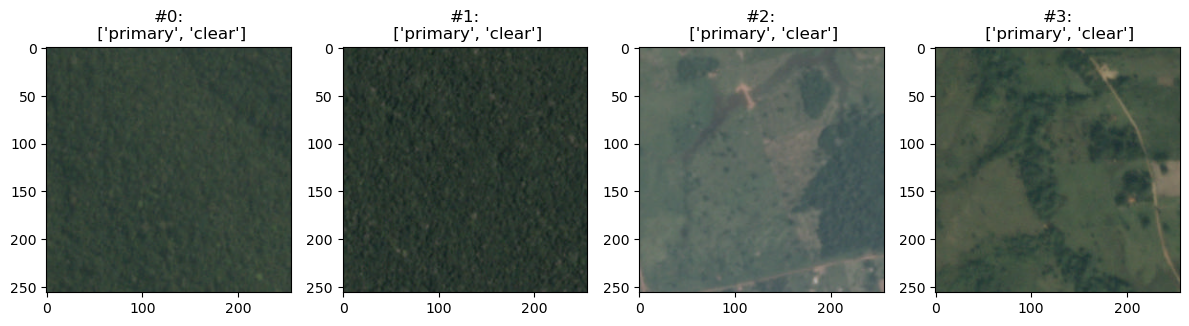

187it [05:23,  1.73s/it]


Validating


62it [01:09,  1.12s/it]


Training


1it [00:01,  1.53s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.667macro f1: 0.105 samples f1: 0.689loss 18.189
Ground metrics: micro f1: 0.629macro f1: 0.069 samples f1: 0.697 loss 0.221
Cloud metrics : 0.703125 and loss:17.96875


31it [00:53,  1.71s/it]

iter: 30 training:micro f1: 0.690macro f1: 0.105 samples f1: 0.706loss 17.901
Ground metrics:micro f1: 0.663macro f1: 0.069 samples f1: 0.719loss 0.193
Cloud metrics : 0.7109375 and loss:17.70833396911621


61it [01:45,  1.71s/it]

iter: 60 training:micro f1: 0.683macro f1: 0.106 samples f1: 0.705loss 17.401
Ground metrics:micro f1: 0.651macro f1: 0.070 samples f1: 0.733loss 0.213
Cloud metrics : 0.703125 and loss:17.1875


90it [02:32,  1.64s/it]

iter: 90 training:micro f1: 0.644macro f1: 0.103 samples f1: 0.657loss 20.023
Ground metrics:micro f1: 0.617macro f1: 0.069 samples f1: 0.681loss 0.231
Cloud metrics : 0.65625 and loss:19.791667938232422


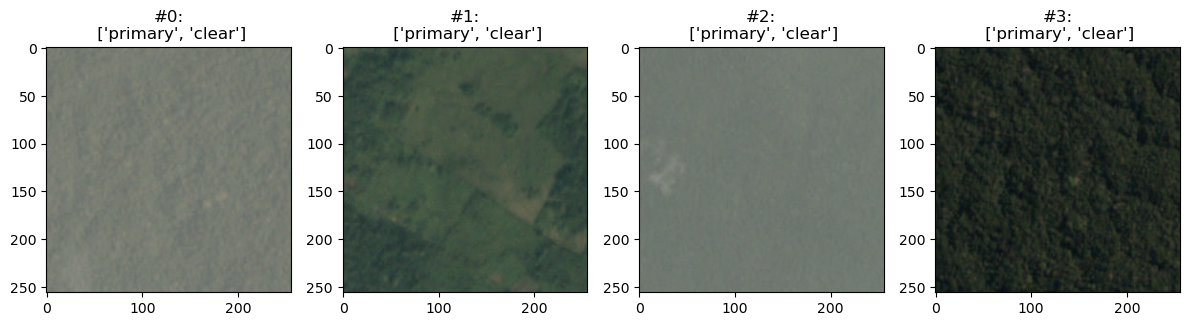

121it [03:26,  1.73s/it]

iter:120 training:micro f1: 0.700macro f1: 0.107 samples f1: 0.713loss 15.304
Ground metrics:micro f1: 0.656macro f1: 0.069 samples f1: 0.720loss 0.200
Cloud metrics : 0.7421875 and loss:15.104166984558105


151it [04:16,  1.65s/it]

iter:150 training:micro f1: 0.656macro f1: 0.106 samples f1: 0.675loss 17.424
Ground metrics:micro f1: 0.605macro f1: 0.069 samples f1: 0.671loss 0.236
Cloud metrics : 0.71875 and loss:17.1875


180it [05:03,  1.60s/it]

iter:180 training:micro f1: 0.680macro f1: 0.106 samples f1: 0.695loss 15.856
Ground metrics:micro f1: 0.633macro f1: 0.069 samples f1: 0.689loss 0.231
Cloud metrics : 0.7109375 and loss:15.625


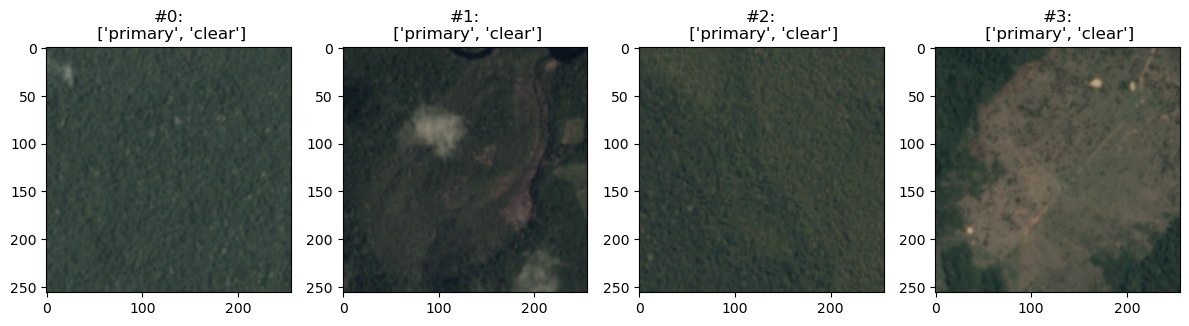

187it [05:15,  1.69s/it]


Validating


62it [01:04,  1.04s/it]


Training


1it [00:01,  1.46s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.641macro f1: 0.105 samples f1: 0.654loss 17.171
Ground metrics: micro f1: 0.582macro f1: 0.068 samples f1: 0.633 loss 0.244
Cloud metrics : 0.7109375 and loss:16.92708396911621


31it [00:49,  1.60s/it]

iter: 30 training:micro f1: 0.674macro f1: 0.105 samples f1: 0.694loss 17.662
Ground metrics:micro f1: 0.640macro f1: 0.069 samples f1: 0.704loss 0.214
Cloud metrics : 0.6953125 and loss:17.447917938232422


61it [01:38,  1.61s/it]

iter: 60 training:micro f1: 0.677macro f1: 0.103 samples f1: 0.681loss 20.514
Ground metrics:micro f1: 0.674macro f1: 0.069 samples f1: 0.736loss 0.202
Cloud metrics : 0.6484375 and loss:20.3125


90it [02:25,  1.60s/it]

iter: 90 training:micro f1: 0.719macro f1: 0.108 samples f1: 0.751loss 14.255
Ground metrics:micro f1: 0.676macro f1: 0.070 samples f1: 0.761loss 0.193
Cloud metrics : 0.7578125 and loss:14.0625


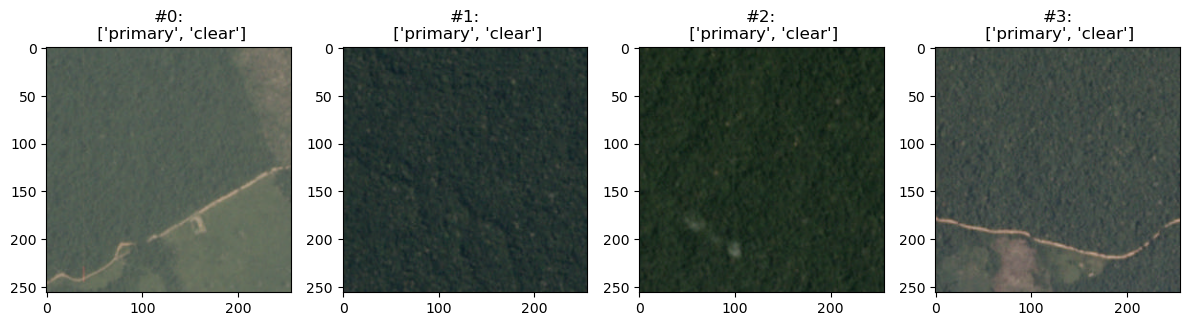

121it [03:16,  1.62s/it]

iter:120 training:micro f1: 0.662macro f1: 0.104 samples f1: 0.683loss 19.230
Ground metrics:micro f1: 0.638macro f1: 0.069 samples f1: 0.708loss 0.220
Cloud metrics : 0.6640625 and loss:19.010417938232422


151it [04:05,  1.62s/it]

iter:150 training:micro f1: 0.669macro f1: 0.105 samples f1: 0.683loss 18.189
Ground metrics:micro f1: 0.633macro f1: 0.069 samples f1: 0.702loss 0.220
Cloud metrics : 0.703125 and loss:17.96875


180it [04:52,  1.60s/it]

iter:180 training:micro f1: 0.727macro f1: 0.108 samples f1: 0.744loss 14.509
Ground metrics:micro f1: 0.686macro f1: 0.069 samples f1: 0.740loss 0.186
Cloud metrics : 0.7734375 and loss:14.322916984558105


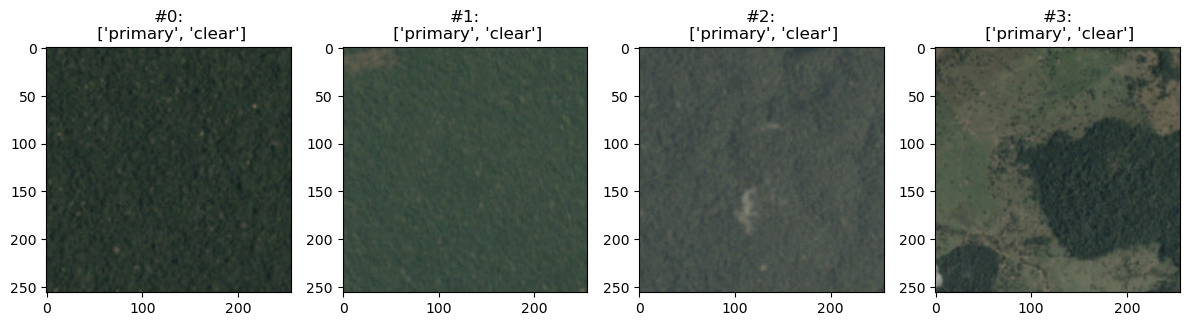

187it [05:05,  1.63s/it]


Validating


62it [01:04,  1.03s/it]


Training


1it [00:01,  1.38s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.644macro f1: 0.104 samples f1: 0.654loss 17.165
Ground metrics: micro f1: 0.582macro f1: 0.067 samples f1: 0.640 loss 0.238
Cloud metrics : 0.71875 and loss:16.92708396911621


31it [00:50,  1.60s/it]

iter: 30 training:micro f1: 0.699macro f1: 0.105 samples f1: 0.721loss 18.159
Ground metrics:micro f1: 0.687macro f1: 0.070 samples f1: 0.751loss 0.190
Cloud metrics : 0.6796875 and loss:17.96875


61it [01:36,  1.47s/it]

iter: 60 training:micro f1: 0.674macro f1: 0.107 samples f1: 0.692loss 13.506
Ground metrics:micro f1: 0.598macro f1: 0.068 samples f1: 0.663loss 0.224
Cloud metrics : 0.765625 and loss:13.28125


90it [02:20,  1.53s/it]

iter: 90 training:micro f1: 0.693macro f1: 0.107 samples f1: 0.706loss 15.070
Ground metrics:micro f1: 0.637macro f1: 0.068 samples f1: 0.687loss 0.226
Cloud metrics : 0.7578125 and loss:14.84375


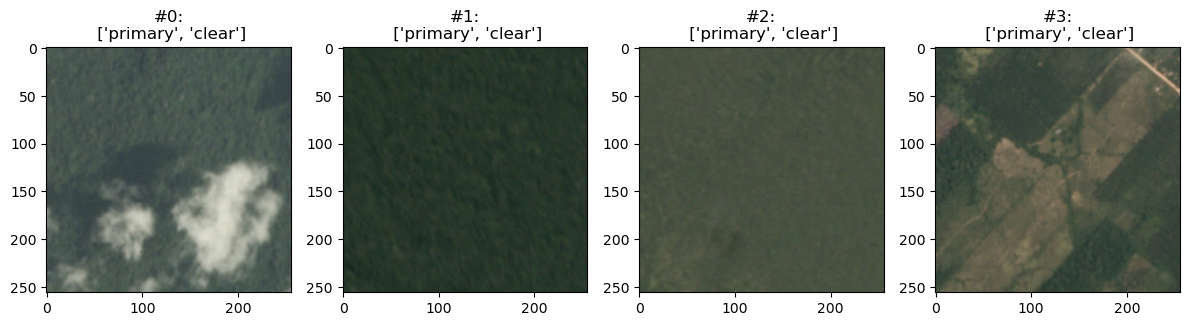

121it [03:08,  1.51s/it]

iter:120 training:micro f1: 0.683macro f1: 0.105 samples f1: 0.692loss 18.165
Ground metrics:micro f1: 0.657macro f1: 0.069 samples f1: 0.705loss 0.196
Cloud metrics : 0.6953125 and loss:17.96875


151it [03:54,  1.53s/it]

iter:150 training:micro f1: 0.704macro f1: 0.105 samples f1: 0.715loss 16.601
Ground metrics:micro f1: 0.674macro f1: 0.068 samples f1: 0.724loss 0.195
Cloud metrics : 0.71875 and loss:16.40625


180it [04:38,  1.55s/it]

iter:180 training:micro f1: 0.710macro f1: 0.108 samples f1: 0.724loss 13.232
Ground metrics:micro f1: 0.650macro f1: 0.069 samples f1: 0.708loss 0.211
Cloud metrics : 0.7734375 and loss:13.020833969116211


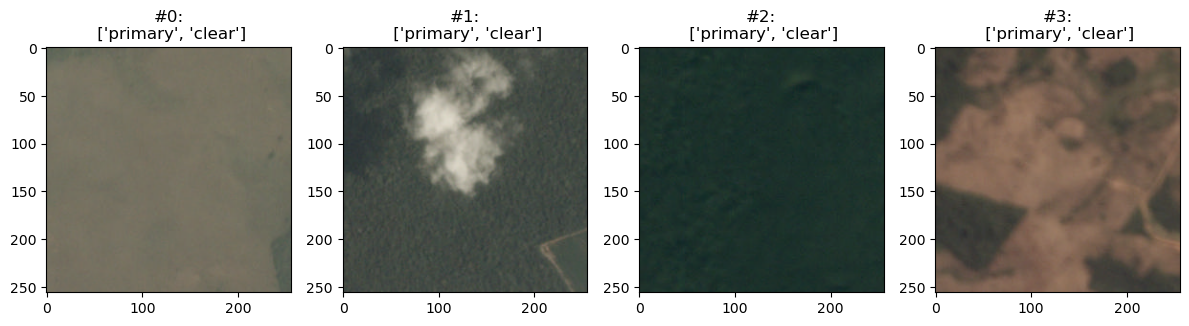

187it [04:51,  1.56s/it]


Validating


62it [01:00,  1.02it/s]


Training


1it [00:01,  1.39s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.666macro f1: 0.106 samples f1: 0.678loss 17.927
Ground metrics: micro f1: 0.625macro f1: 0.069 samples f1: 0.686 loss 0.219
Cloud metrics : 0.7109375 and loss:17.70833396911621


31it [00:46,  1.50s/it]

iter: 30 training:micro f1: 0.674macro f1: 0.108 samples f1: 0.699loss 16.627
Ground metrics:micro f1: 0.628macro f1: 0.071 samples f1: 0.703loss 0.221
Cloud metrics : 0.7265625 and loss:16.40625


61it [01:32,  1.55s/it]

iter: 60 training:micro f1: 0.728macro f1: 0.109 samples f1: 0.745loss 11.924
Ground metrics:micro f1: 0.665macro f1: 0.069 samples f1: 0.731loss 0.205
Cloud metrics : 0.796875 and loss:11.71875


90it [02:17,  1.52s/it]

iter: 90 training:micro f1: 0.666macro f1: 0.106 samples f1: 0.685loss 16.638
Ground metrics:micro f1: 0.617macro f1: 0.069 samples f1: 0.689loss 0.232
Cloud metrics : 0.7109375 and loss:16.40625


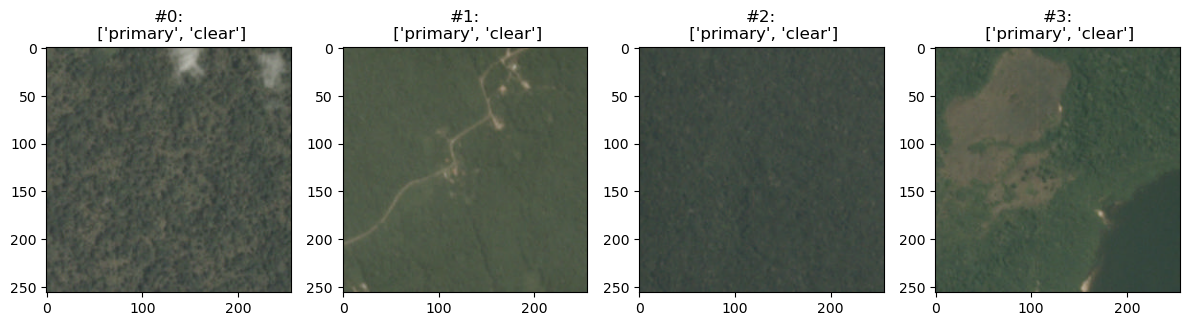

121it [03:05,  1.57s/it]

iter:120 training:micro f1: 0.668macro f1: 0.107 samples f1: 0.688loss 15.078
Ground metrics:micro f1: 0.602macro f1: 0.069 samples f1: 0.677loss 0.234
Cloud metrics : 0.75 and loss:14.84375


151it [03:50,  1.52s/it]

iter:150 training:micro f1: 0.701macro f1: 0.107 samples f1: 0.720loss 16.860
Ground metrics:micro f1: 0.669macro f1: 0.069 samples f1: 0.734loss 0.193
Cloud metrics : 0.7421875 and loss:16.666667938232422


180it [04:35,  1.52s/it]

iter:180 training:micro f1: 0.633macro f1: 0.100 samples f1: 0.633loss 22.607
Ground metrics:micro f1: 0.624macro f1: 0.067 samples f1: 0.662loss 0.211
Cloud metrics : 0.6171875 and loss:22.39583396911621


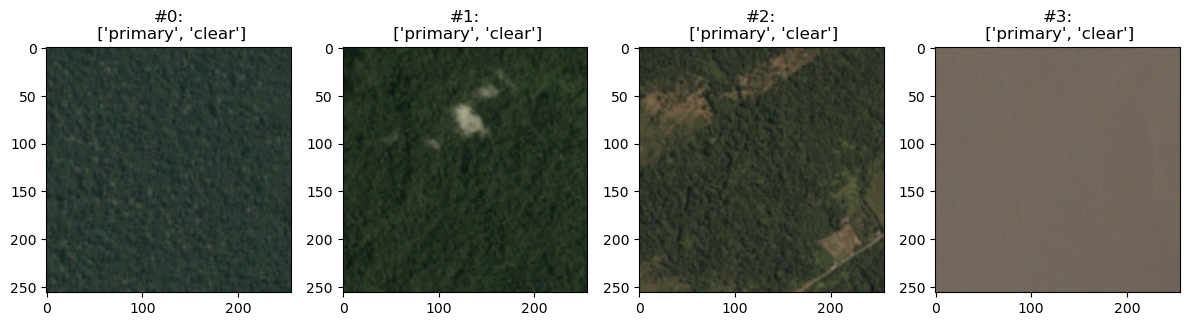

187it [04:47,  1.54s/it]


Validating


62it [01:03,  1.02s/it]


Training


1it [00:01,  1.33s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.679macro f1: 0.107 samples f1: 0.701loss 16.367
Ground metrics: micro f1: 0.634macro f1: 0.070 samples f1: 0.710 loss 0.221
Cloud metrics : 0.7265625 and loss:16.14583396911621


31it [00:48,  1.60s/it]

iter: 30 training:micro f1: 0.682macro f1: 0.106 samples f1: 0.697loss 16.882
Ground metrics:micro f1: 0.640macro f1: 0.069 samples f1: 0.696loss 0.215
Cloud metrics : 0.7265625 and loss:16.666667938232422


61it [01:34,  1.57s/it]

iter: 60 training:micro f1: 0.693macro f1: 0.106 samples f1: 0.709loss 15.571
Ground metrics:micro f1: 0.642macro f1: 0.068 samples f1: 0.700loss 0.207
Cloud metrics : 0.75 and loss:15.364583969116211


90it [02:19,  1.56s/it]

iter: 90 training:micro f1: 0.681macro f1: 0.105 samples f1: 0.691loss 19.471
Ground metrics:micro f1: 0.663macro f1: 0.069 samples f1: 0.705loss 0.200
Cloud metrics : 0.6953125 and loss:19.27083396911621


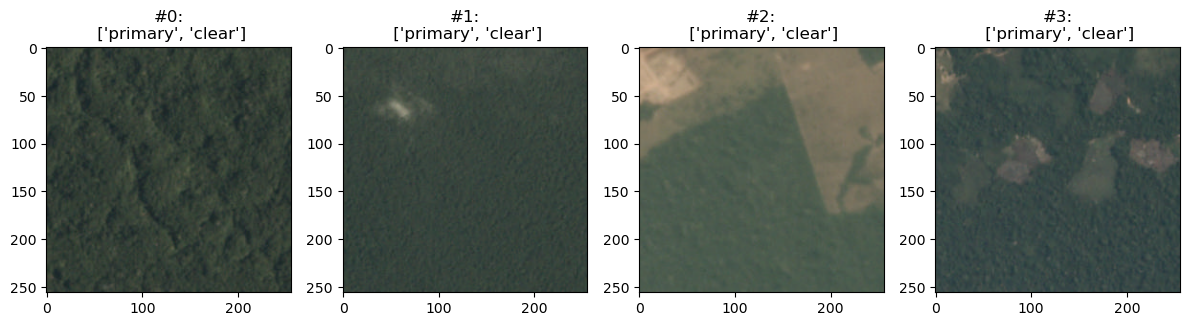

121it [03:07,  1.55s/it]

iter:120 training:micro f1: 0.657macro f1: 0.104 samples f1: 0.685loss 19.752
Ground metrics:micro f1: 0.635macro f1: 0.069 samples f1: 0.709loss 0.220
Cloud metrics : 0.65625 and loss:19.53125


151it [03:53,  1.54s/it]

iter:150 training:micro f1: 0.680macro f1: 0.108 samples f1: 0.709loss 13.770
Ground metrics:micro f1: 0.611macro f1: 0.069 samples f1: 0.699loss 0.229
Cloud metrics : 0.765625 and loss:13.541666984558105


180it [07:38,  1.96s/it]

iter:180 training:micro f1: 0.688macro f1: 0.107 samples f1: 0.713loss 15.834
Ground metrics:micro f1: 0.640macro f1: 0.069 samples f1: 0.716loss 0.209
Cloud metrics : 0.7421875 and loss:15.625


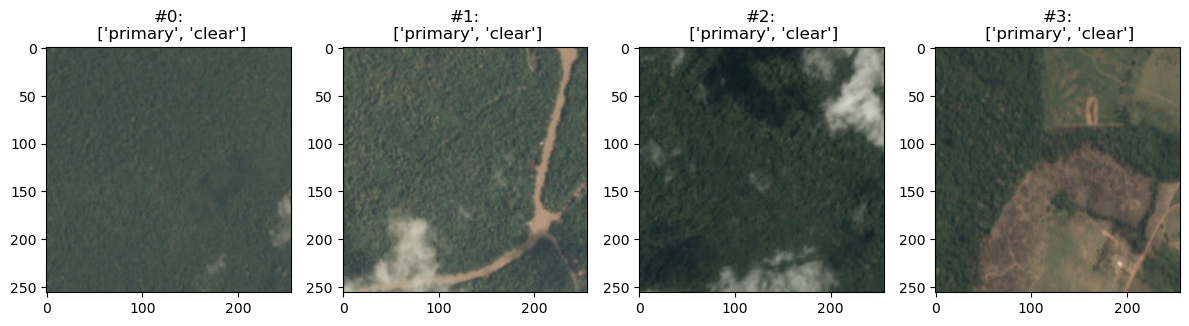

183it [07:43,  1.67s/it]

In [ ]:
epochs_number = 10

The_results = train_dual(ground_model,cloud_model, train_dataloader, validation_dataloader, device=device, ground_optimizer= ground_optim, cloud_optimizer=cloud_optim, lr = learning_rate, epochs=epochs_number, ground_loss_fn= ground_crit, cloud_loss_fn=cloud_crit)

## 5b) Saving the results into a Json file

In [20]:
import json

# create json object from dictionary
js = json.dumps(The_results)

# open file for writing, "w"
name = f"dual_training_results_{epochs_number}epochs_{batch_size}batchsize_{learning_rate}lr_{ground_crit}_{cloud_crit}_crit_{str(ground_optim).split()[0]} _and_{str(ground_optim).split()[0]}_optim.json"
f = open(name,"a")

# write json object to file
f.write(js)

# close file
f.close()

## 5c) Plotting the training phases metrics

In [21]:
json_file = "dual_training_results_3epochs_128batchsize_0.01lr_BCEWithLogitsLoss()_BCELoss()_crit_Adam _and_Adam_optim.json"
if json_file:
    print("Loading results from json file...")
    The_results = json.load(json_file)

Loading results from json file...


AttributeError: 'str' object has no attribute 'read'

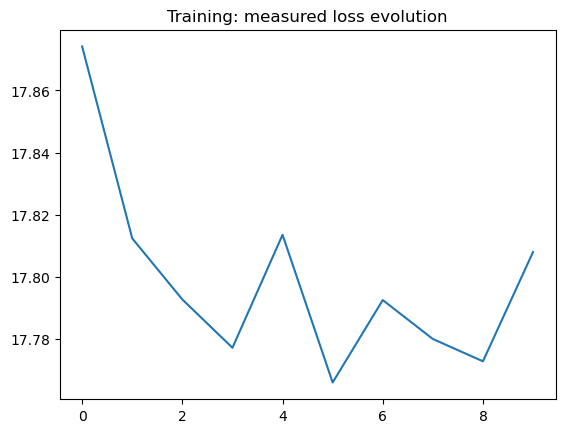

In [22]:
plt.figure()
plt.plot(np.array(The_results['training']['total_loss']))
plt.title('Training: measured loss evolution')
plt.show()

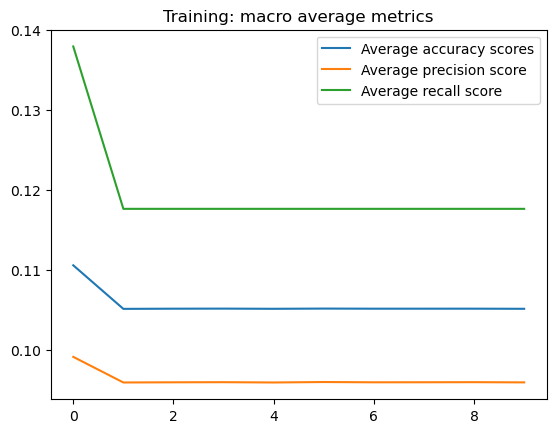

In [23]:
plt.figure()
plt.plot(np.array(The_results['training']['macro/f1']))
plt.plot(np.array(The_results['training']['macro/precision']))
plt.plot(np.array(The_results['training']['macro/recall']))
plt.legend(['Average accuracy scores', 'Average precision score', 'Average recall score'])
plt.title('Training: macro average metrics')
plt.show()

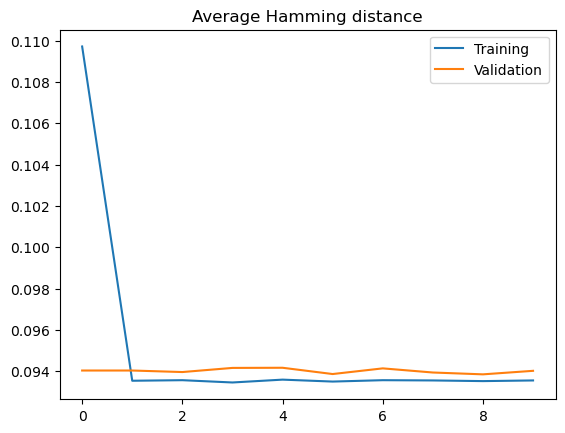

In [24]:
plt.figure()
plt.plot(np.array(The_results['training']['hamming_loss']), label='Training')
plt.plot(np.array(The_results['validating']['hamming_loss']), label='Validation')
plt.legend()
plt.title('Average Hamming distance')
plt.show()

## 6) TESTING

In [ ]:
# store stats
losses, accuracies = [], []
count = 0
for batch in tqdm(test_dataloader):
    # TODO run prediction_step
    loss, accuracy, predictions = batch_prediction(batch, model, device = 'cuda')

    # append to stats
    losses.append(loss)
    accuracies.append(accuracy)
    if count == 0:
        all_pred = predictions
        count = 1
    else :
        all_pred = np.vstack((all_pred,predictions))
# average val losses and accuracies over batches
losses, accuracies = np.stack(losses).mean(), np.stack(accuracies).mean()
print(f"valloss {losses:.2f}, val accuracy {accuracies*100:.2f}%")

In [ ]:
all_pred

In [ ]:
mean_pred = np.stack(all_pred, axis = 0).mean(axis=0)
plt.figure()
plt.bar(x = range(17), height=mean_pred)
plt.xticks(range(17))
plt.title("Accuracy of each class")
plt.show()

# Saving Models

In [25]:
torch.save(ground_model.state_dict(), "groundmodel_multilabel_classification.pth")
torch.save(cloud_model.state_dict(), "cloudmodel_classifier.pth")
print("Saved PyTorch Model State")

Saved PyTorch Model State
